In [1]:
#import useful libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import product
import scipy.stats as ss

In [2]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

In [9]:
df = pd.read_pickle('./datasets/soft/clean/hist.pkl')
emp = pd.read_pickle('./datasets/soft/clean/emp.pkl')

In [15]:
cat_cols = ['IsTrainee', 'CompetenceGroupID', 'PaymentTypeId', 'PositionLevel', 'LanguageLevelID',
            'DevCenterID', 'SBUID', 'PositionID', 'CustomerID', 'ProjectID', 'IsInternalProject', 
            'OnSite', 'FunctionalOfficeID']
num_cols = ['WageGross', 'Utilization', 'HourVacation', 'BonusOneTime', 'MonthOnPosition', 
            'MonthOnSalary']
target_col = 'Dismissed'

Let's generate target column, that shows that employee leaved or didn't leave the job in the next month.

In [10]:
emp[target_col] = (~emp['DismissalDate'].isna()).astype('int64')
df = df.merge(emp[['EmployeeID', target_col]], on='EmployeeID')

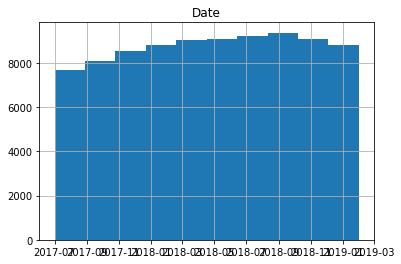

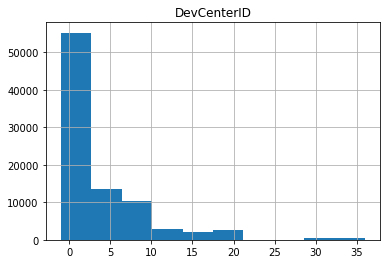

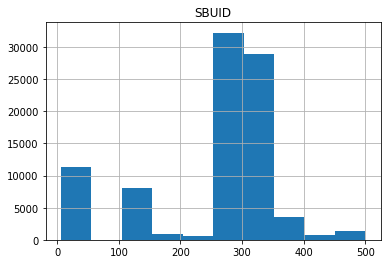

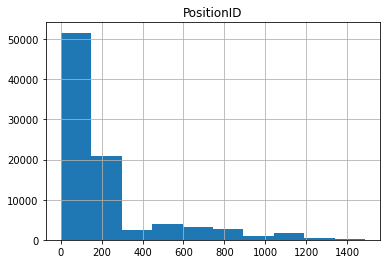

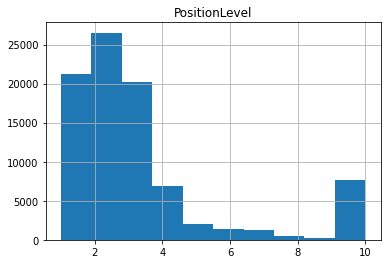

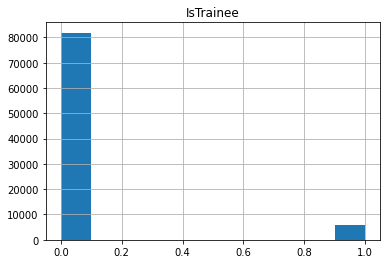

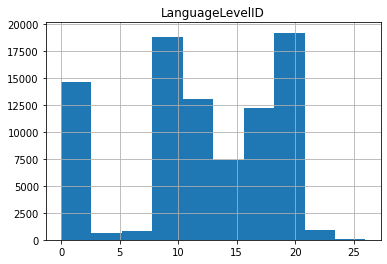

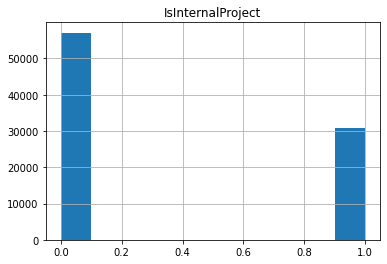

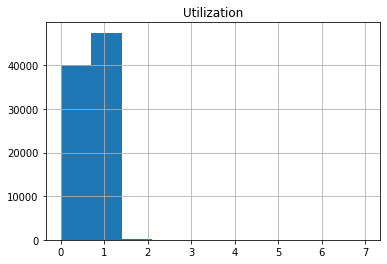

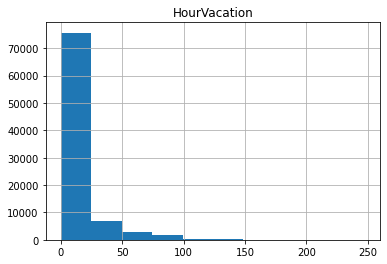

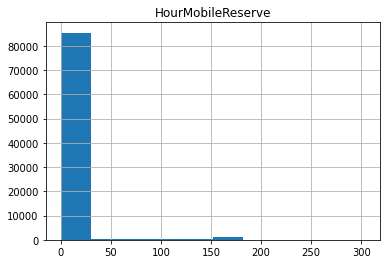

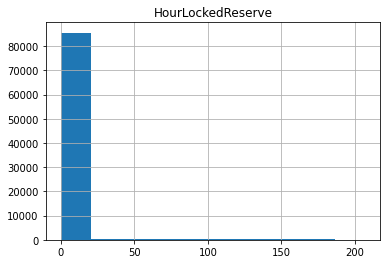

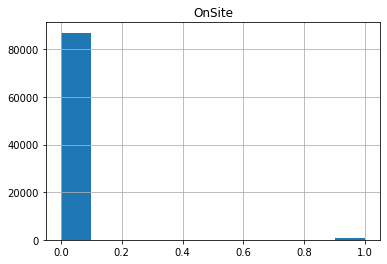

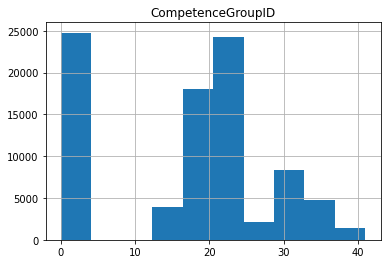

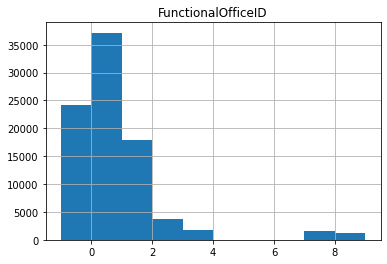

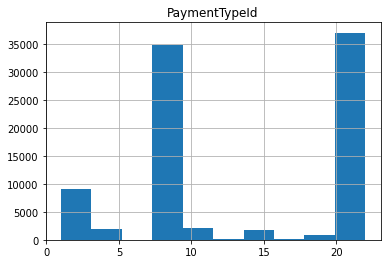

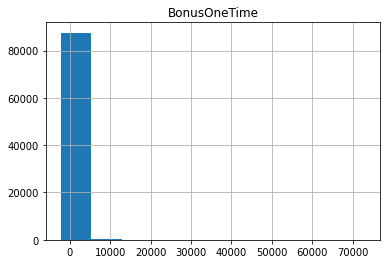

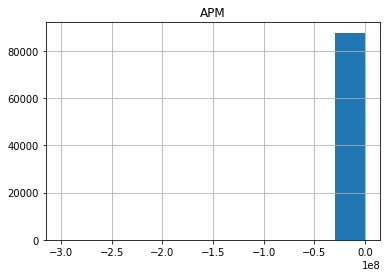

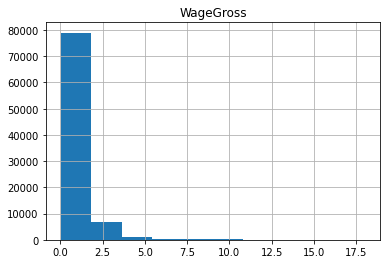

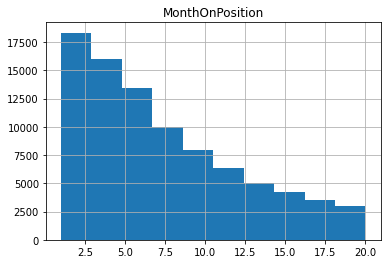

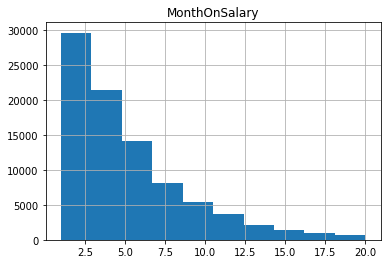

In [6]:
for col in [col for col in df.columns if col not in ['EmployeeID', 'CustomerID', 'ProjectID']]:
    df[col].hist()
    plt.title(col)
    plt.show()

Although we can see a distribution of features, it is biased.  
For each month of employee work we have a unique row. Therefore, feature values for employees who works longer appears in unreasonably great number.

In [7]:
for col in cat_cols:
    _, uniqs = pd.factorize(df[col])
    print(f'Unique values for {col}: {uniqs}')

Unique values for IsTrainee: Int64Index([0, 1], dtype='int64')
Unique values for CompetenceGroupID: Int64Index([15, 23,  0, 16, 17, 36, 31, 29, 20, 21, 19, 22, 33, 39, 32, 25, 35,
            28, 24, 37, 27, 40, 34, 26, 41],
           dtype='int64')
Unique values for PaymentTypeId: Int64Index([9, 22, 1, 3, 21, 20, 4, 10, 15, 19, 8, 16, 5, 13, 12, 14, 18, 11], dtype='int64')
Unique values for PositionLevel: Int64Index([2, 3, 1, 10, 4, 8, 5, 6, 7, 9], dtype='int64')
Unique values for LanguageLevelID: Int64Index([11, 20, 5, 15, 19, 18, 13, 10, 9, 23, 0, 1, 14, 7, 3, 6, 24, 26], dtype='int64')
Unique values for DevCenterID: Int64Index([ 3,  1,  2,  5, 10,  8, 13, -1,  0,  4, 16, 18, 36,  9, 14, 20, 32,
            35, 34,  6, 31, 19, 33, 30, 12],
           dtype='int64')
Unique values for SBUID: Int64Index([292, 332, 284,  55, 120, 272, 308, 352, 330, 255,
            ...
            412, 273, 417, 439, 355, 421, 222, 410, 422, 297],
           dtype='int64', length=169)
Unique values fo

Features SBUID, PositionID, CustomerID, ProjectID have too many unique values.  
Sometimes, it is worth to pick the most popular ones and join other values in 1 group.

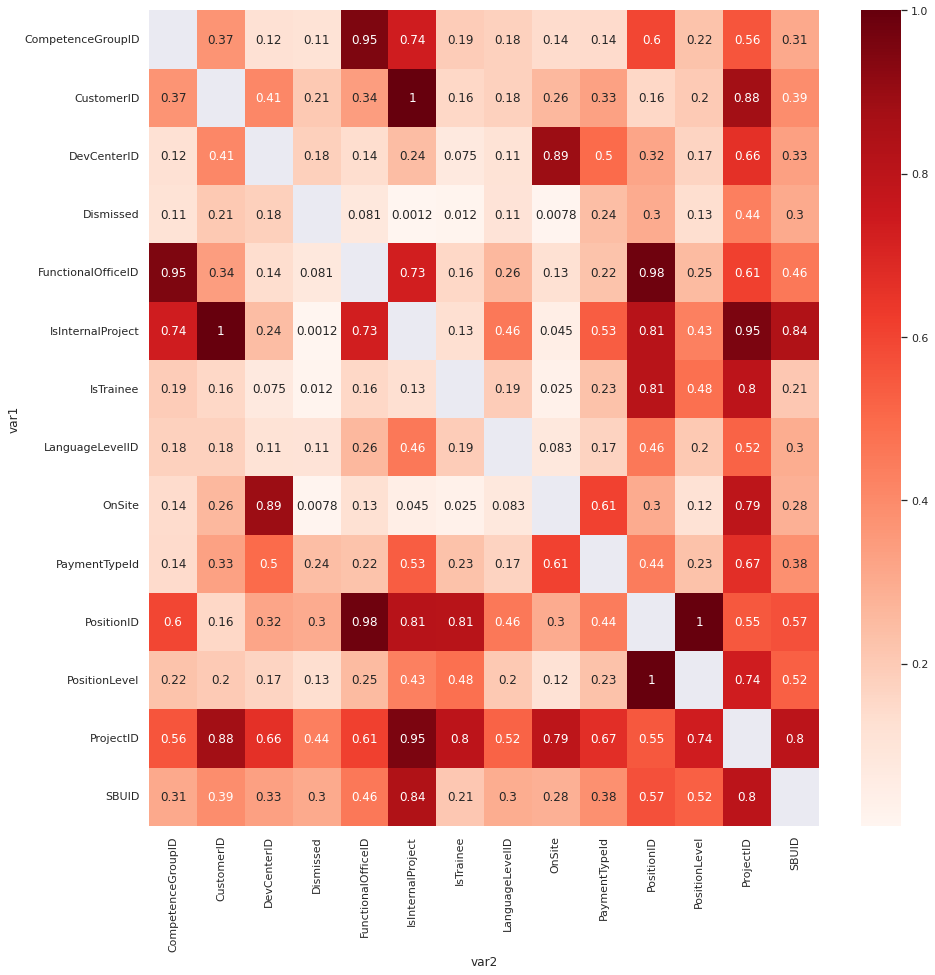

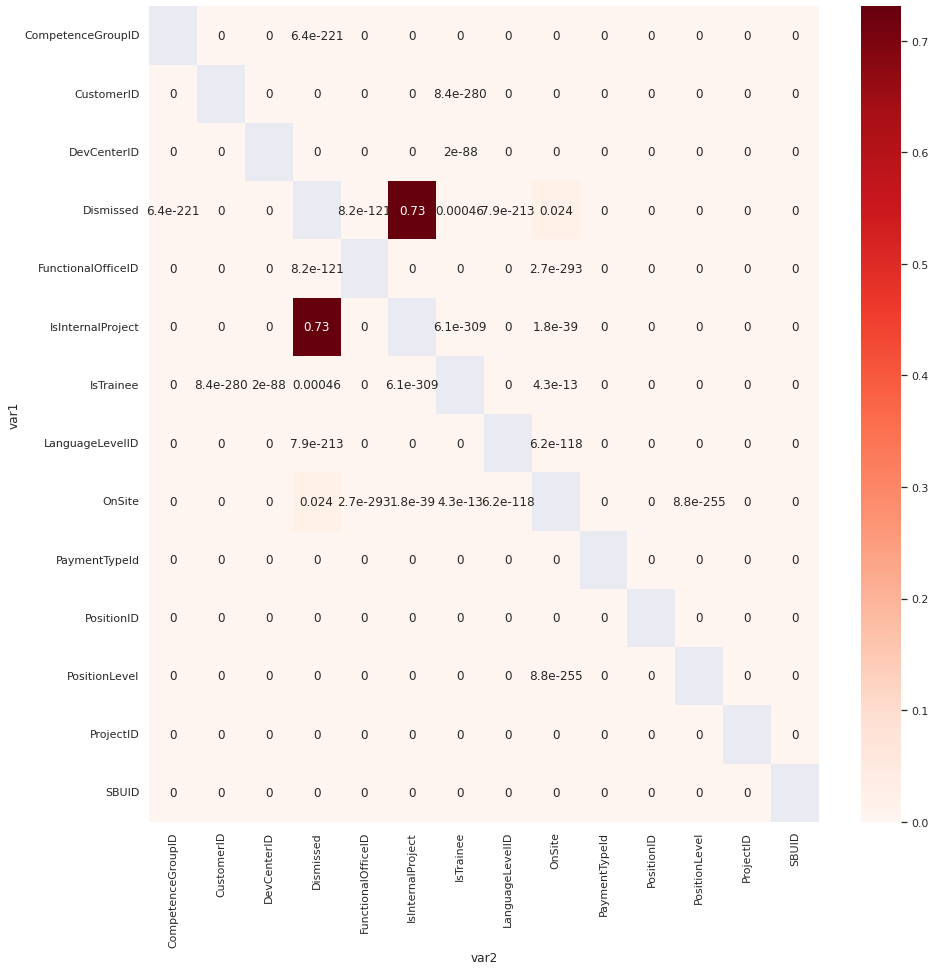

In [17]:
sns.set(rc = {'figure.figsize':(15, 15)})

def calc_cramer_pval(df, cat_cols, target_col):
    '''
    Calculate Cramer's V and p-values for corresponding association values.
    '''
    cat_prod = list(product(cat_cols + [target_col], cat_cols + [target_col], repeat=1))

    pval_res = []
    cram_res = []
    for i in cat_prod:
        if i[0] != i[1]:
            pval_res.append((i[0], i[1],
                          list(ss.chi2_contingency(pd.crosstab(df[i[0]], df[i[1]])))[1]))
            cram_res.append((i[0], i[1],
                            ss.contingency.association(pd.crosstab(df[i[0]], df[i[1]]))))

    pval_df = pd.DataFrame(pval_res, columns = ["var1", "var2", "coeff"])
    cram_df = pd.DataFrame(cram_res, columns = ["var1", "var2", "coeff"])
    pval_df = pval_df.pivot(index = "var1", columns = "var2", values = "coeff")
    cram_df = cram_df.pivot(index = "var1", columns = "var2", values = "coeff")
    
    return cram_df, pval_df

def plot_cramer_pval(cram_df, chi_df):
    sns.heatmap(cram_df, annot = True, cmap = 'Reds')
    plt.show()
    sns.heatmap(chi_df, annot = True, cmap = 'Reds')
    plt.show()


cram_df, pval_df = calc_cramer_pval(df, cat_cols, target_col)
plot_cramer_pval(cram_df, pval_df)

Features with high association need to be investigeted further. If these features actually have 1-to-1 association, then they can be removed.

In [22]:
assoc_mat = cram_df
sign_mat = chi_df

assoc_thr = 0.6
sign_thr = 0.05

tril_mat = assoc_mat.copy().to_numpy()
triu_idx = np.triu_indices(tril_mat.shape[0])
tril_mat[triu_idx] = 0
assoc_idx = np.column_stack(np.where(tril_mat >= assoc_thr))
assoc_info = list()
for r, c in assoc_idx:
    sign_val = sign_mat.iat[r, c]
    assoc_val = assoc_mat.iat[r, c]
    if sign_val <= sign_thr:
        assoc_info.append((assoc_mat.index[r], assoc_mat.columns[c], assoc_val, sign_val))
assoc_info = pd.DataFrame(assoc_info, columns = ["f1", "f2", "cramer", "p_val"])
print(assoc_info.sort_values(by=["f1"], ascending=False, axis=0))

                    f1                  f2    cramer  p_val
19               SBUID           ProjectID  0.801057    0.0
18               SBUID   IsInternalProject  0.837446    0.0
11           ProjectID         DevCenterID  0.662102    0.0
17           ProjectID       PositionLevel  0.735805    0.0
16           ProjectID       PaymentTypeId  0.669881    0.0
15           ProjectID              OnSite  0.793392    0.0
14           ProjectID           IsTrainee  0.800706    0.0
13           ProjectID   IsInternalProject  0.953294    0.0
12           ProjectID  FunctionalOfficeID  0.612070    0.0
10           ProjectID          CustomerID  0.876226    0.0
9        PositionLevel          PositionID  1.000000    0.0
8           PositionID           IsTrainee  0.811847    0.0
7           PositionID   IsInternalProject  0.812779    0.0
6           PositionID  FunctionalOfficeID  0.983652    0.0
5        PaymentTypeId              OnSite  0.609692    0.0
4               OnSite         DevCenter

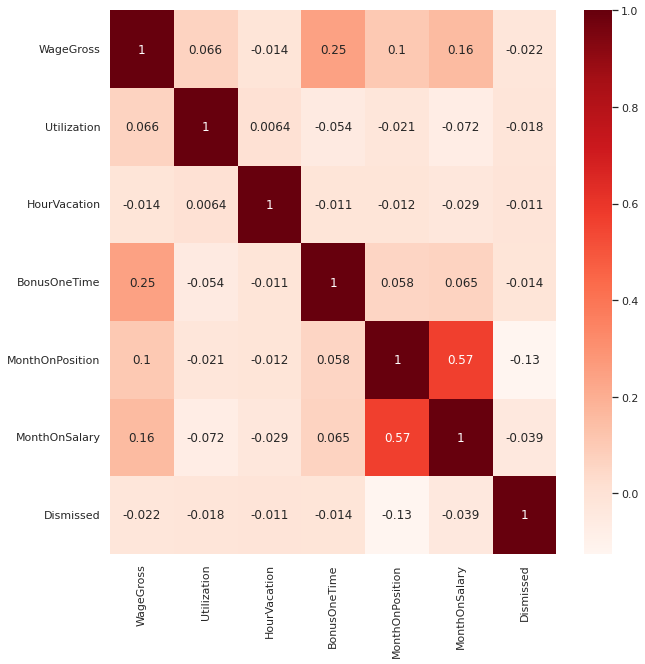

In [19]:
corr_mat = df[num_cols + ['Dismissed']].corr()

sns.set(rc = {'figure.figsize':(10,10)})
sns.heatmap(corr_mat, annot=True, cmap='Reds')
plt.show()

In [21]:
corr_thr = 0.5

tril_mat = corr_mat.copy().to_numpy()
triu_idx = np.triu_indices(tril_mat.shape[0])
tril_mat[triu_idx] = 0
corr_idx = np.column_stack(np.where(tril_mat >= corr_thr))
corr_info = list()
for r, c in corr_idx:
    corr_val = corr_mat.iat[r, c]
    corr_info.append((corr_mat.index[r], corr_mat.columns[c], corr_val))
corr_info = pd.DataFrame(corr_info, columns = ["f1", "f2", "pearson"])
print(corr_info.sort_values(by=["pearson"], ascending=False, axis=0))

              f1               f2   pearson
0  MonthOnSalary  MonthOnPosition  0.566621


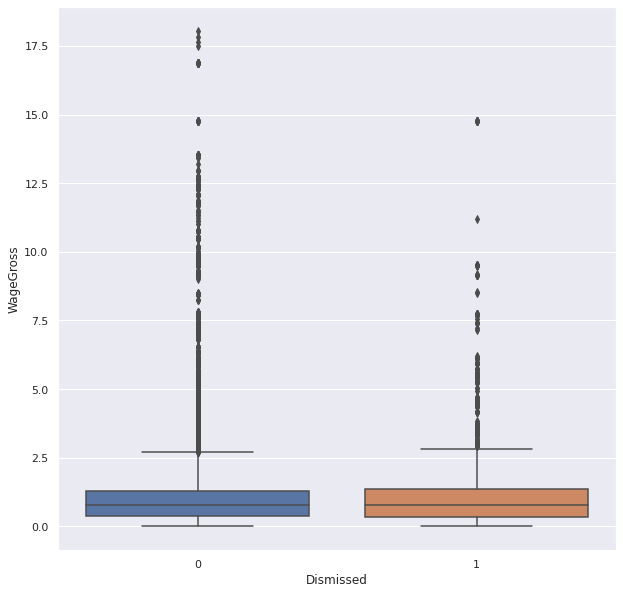

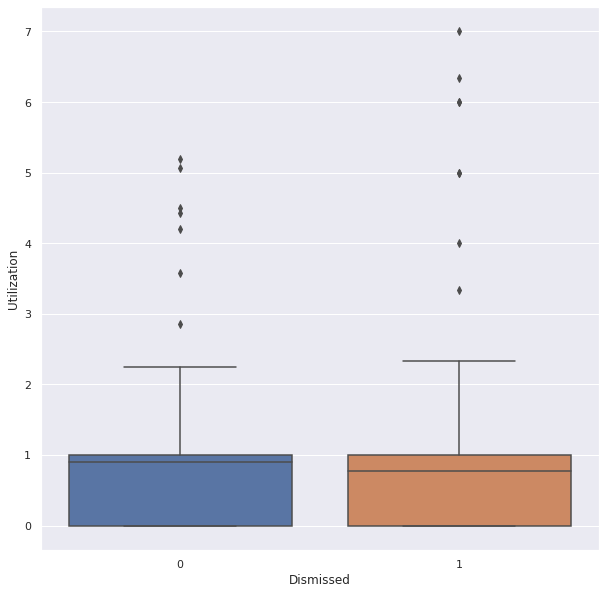

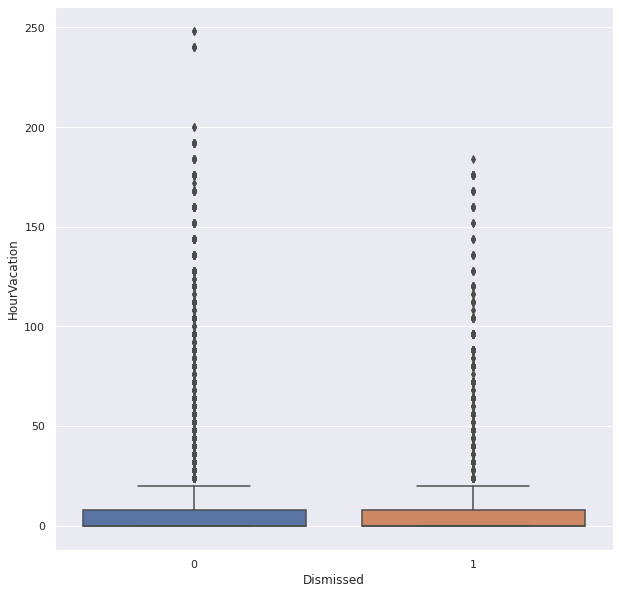

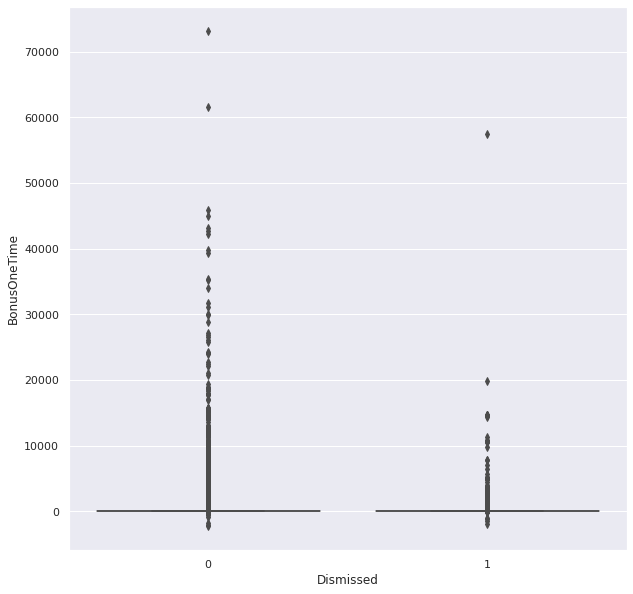

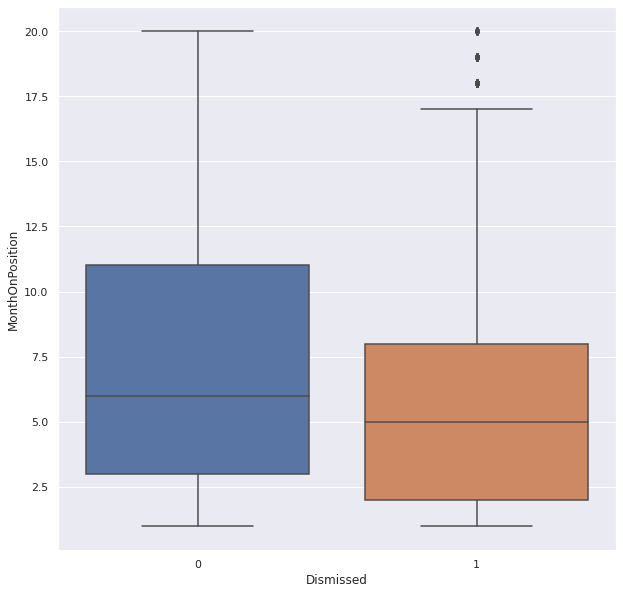

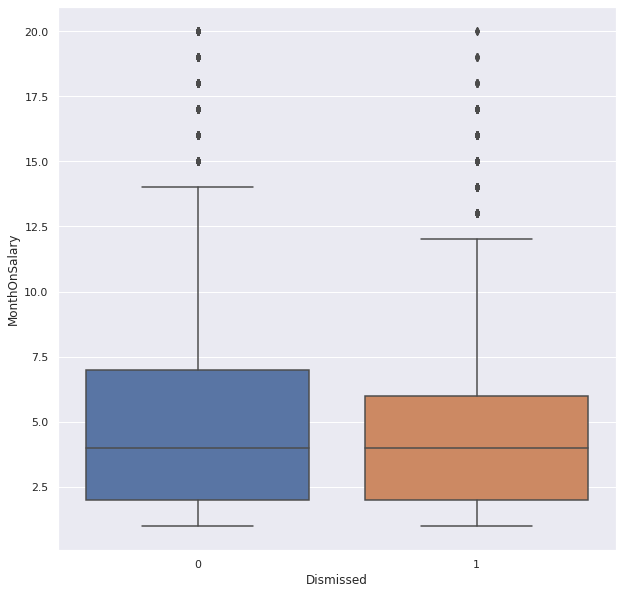

In [23]:
for col in num_cols:
    sns.boxplot(x=df['Dismissed'], y=df[col])
    plt.show()

People who worked longer on the position has less chance to dismiss.

Let's analyze only last month with information of each employee.

In [24]:
last_month_df = df.groupby('EmployeeID').apply(lambda x: x.sort_values('Date').tail(1))

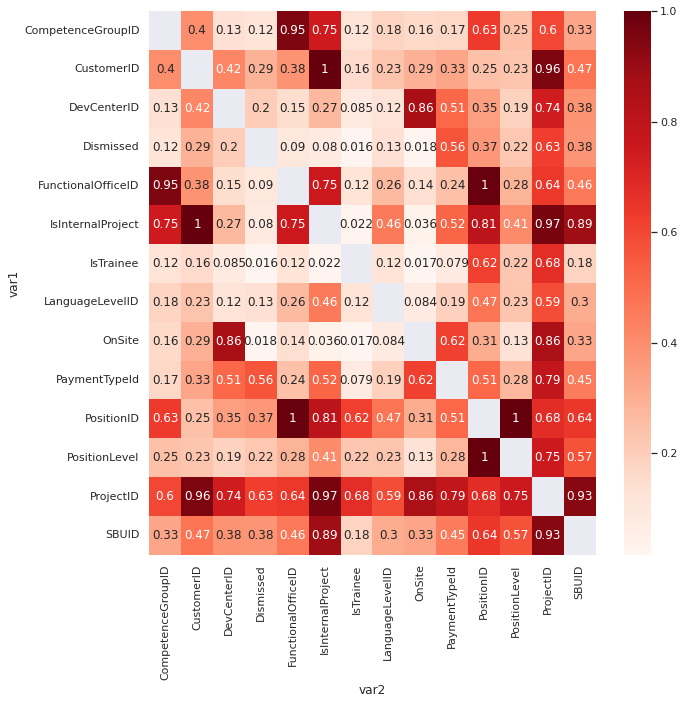

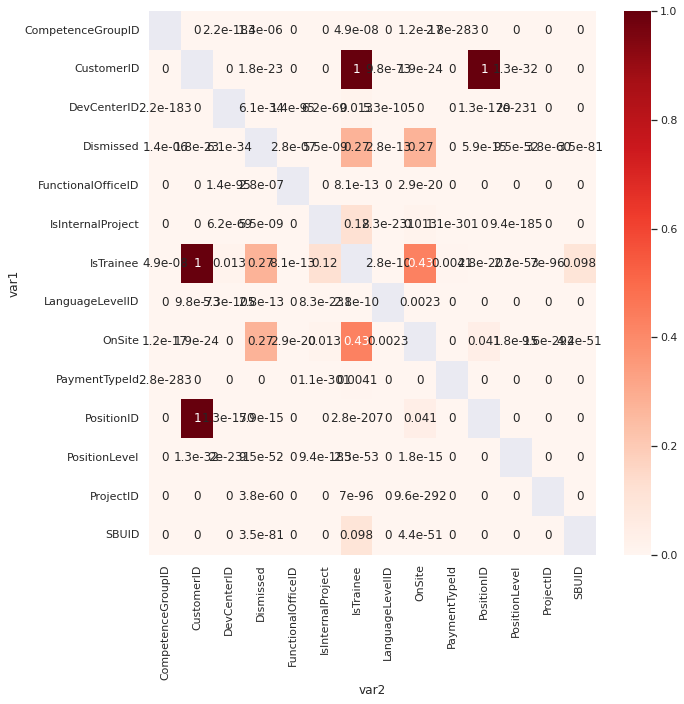

In [25]:
cram_df, pval_df = calc_cramer_pval(last_month_df, cat_cols, target_col)
plot_cramer_pval(cram_df, pval_df)